In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.decomposition import PCA
m = ['', 'o', 's', '^', 'x']

# PCA in Action

We saw previously a simple conceptual introduction to PCA, in that it is a method to find the vectors describing the features over which the largest spread is. 
However, it is not yet clear how it can be used for dimensionality reduction. 
For this, we will use a [real dataset](./example), which is information about 44 different wines. 
The features we are investigating are the column in the data below, while the rows are the different wines. 

In [2]:
data = pd.read_csv('wine_data.csv')

In [3]:
data.head()

,Ethanol,TotalAcid,VolatileA,MalicAcid,pH,LacticAcid,ReSugar,CitricAcid,CO2,Density,FolinC,Glycerol,Methanol,TartaricA,Country
0,13.62,3.54,0.29,0.89,3.71,0.78,1.46,0.31,85.610001,0.99,60.919998,9.72,0.16,1.74,1
1,14.06,3.74,0.59,0.24,3.73,1.25,2.42,0.18,175.199997,1.00,70.639999,10.05,0.20,1.58,1
2,13.74,3.27,0.47,-0.07,3.87,1.13,1.52,0.39,513.739990,0.99,63.590000,10.92,0.18,1.24,1
3,13.95,3.66,0.47,0.09,3.79,1.00,4.17,0.41,379.399994,1.00,73.300003,9.69,0.23,2.26,1
4,14.47,3.66,0.38,0.61,3.70,0.81,1.25,0.14,154.880005,0.99,71.690002,10.81,0.20,1.22,1


We are only printing the first 5 rows of the table, but rest assured there are 44 wines in the dataset. 

In [4]:
print(data.shape)

(44, 15)


In traditional analysis, we would investigate how individual parameters vary. 
Below, we show how the ethanol, glycerol, and methanol content varies as a function of the country that the wine is sourced from. 
However, there is no real trends present in the data.

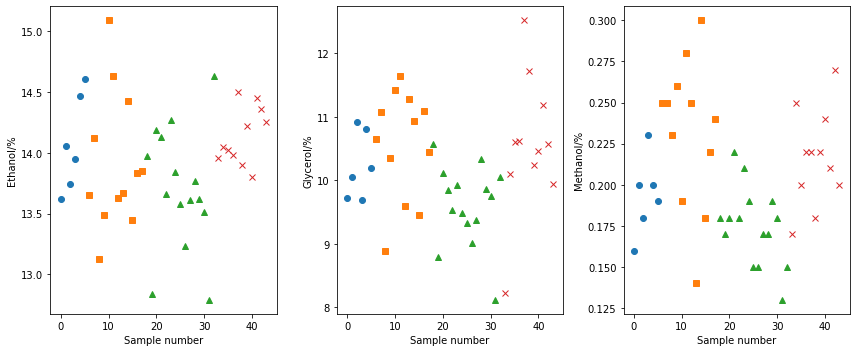

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
for i in range(1, 5):
    ax[0].plot(data.where(data['Country'] == i)['Ethanol'], m[i])
ax[0].set_xlabel('Sample number')
ax[0].set_ylabel('Ethanol/%')
for i in range(1, 5):
    ax[1].plot(data.where(data['Country'] == i)['Glycerol'], m[i])
ax[1].set_xlabel('Sample number')
ax[1].set_ylabel('Glycerol/%')
for i in range(1, 5):
    ax[2].plot(data.where(data['Country'] == i)['Methanol'], m[i])
ax[2].set_xlabel('Sample number')
ax[2].set_ylabel('Methanol/%')
plt.tight_layout()
plt.show()

However, this univariate analysis process removes all covariation in the features. 
For example, if we plot the ethanol contant against the glycerol content, we can see a potentially interesting covariance. 

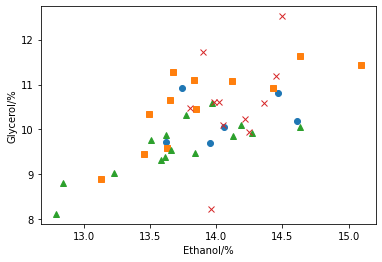

In [7]:
for i in range(1, 5):
    plt.plot(data.where(data['Country'] == i)['Ethanol'], data.where(data['Country'] == i)['Glycerol'], m[i])
plt.xlabel('Ethanol/%')
plt.ylabel('Glycerol/%')
plt.show()

If these two features were completely correlated, it would be possible to describe the dataset completely with a combined feature. 
Let's investigate performing a single component PCA on these two covariant features. 
First it is necessary to normalise the features such that those with large values do no overwhelm the analysis. 
This is achieved with the `sklearn.preprocessing.scale` function, we have also defined an `inverse_scale` helper function that will unnormalise 

In [8]:
from sklearn.preprocessing import scale

In [9]:
def inverse_scale(s, x):
    sigma = np.array(x.std(ddof=0, axis=0))
    mu = np.array(x.mean(axis=0))
    return (s * sigma.T) + mu.T

In [10]:
pca = PCA(n_components=1)
pca.fit(scale(data[['Ethanol', 'Glycerol']]))
X_pca = pca.transform(scale(data[['Ethanol', 'Glycerol']]))

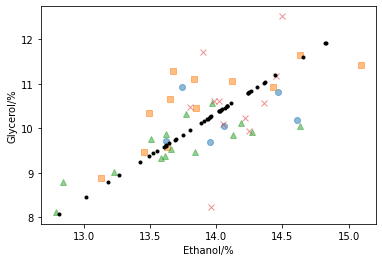

In [11]:
X_new = inverse_scale(pca.inverse_transform(X_pca), data[['Ethanol', 'Glycerol']])
for i in range(1, 5):
    plt.plot(data.where(data['Country'] == i)['Ethanol'], data.where(data['Country'] == i)['Glycerol'], m[i], alpha=0.5)
plt.plot(X_new[:, 0], X_new[:, 1], 'k.')
plt.xlabel('Ethanol/%')
plt.ylabel('Glycerol/%')
plt.show()

Above, we have used PCA with a single component to reduce the description of the covariation of ethanol and glycerol in our wine data. 
Although, the new dataset does not completely capture the dataset that it describes, we have encoded most of the information regarding the relationship between our two features. 

In total, there are 14 features in the data (we are not considering the country that the wine is produced in as a feature as this is essentially our independent variable). 
So, how many principal components should we use to describe the measured data?

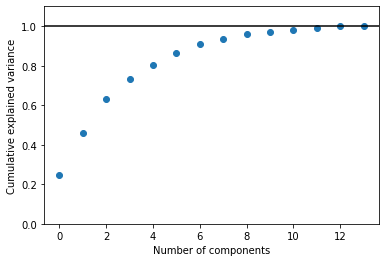

In [12]:
pca = PCA().fit(scale(data.drop('Country', axis=1)))
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'o')
plt.axhline(1, color='k')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.ylim(0, 1.1)
plt.show()

The plot above is a quantification of how much of the total data variance is contained within the first *N* components. 
We can see that using three components is capable of describing more than 50 % of the observed variance, while seven components are required to take this to more than 90 %. 

In [13]:
print(np.cumsum(pca.explained_variance_ratio_))

[0.24443085 0.45713481 0.63175889 0.73170985 0.80571813 0.86427209
 0.91194903 0.93701181 0.96043195 0.97227143 0.98246275 0.99139934
 0.9992006  1.        ]


We can use a plot such as that above to determine how many components we should pay attention to. 
For simplicity going forward (so that we can use standard 2-dimensional plotting), we will only consider the first two principle components. 

In [14]:
pca = PCA(n_components=2)
pca.fit(scale(data.drop('Country', axis=1)))

PCA(n_components=2)

In [15]:
loading_matrix = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_), columns=['PC1', 'PC2'], index=data.columns[:-1])

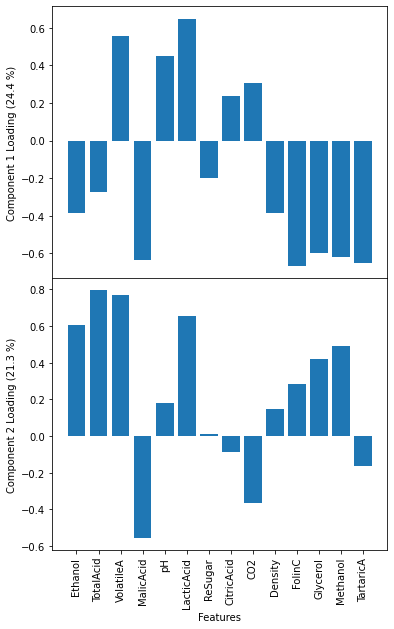

In [16]:
fig = plt.figure(figsize=(6, 10))
gs = gridspec.GridSpec(2, 1) 
ax0 = plt.subplot(gs[0])
ax0.bar(loading_matrix.index, loading_matrix['PC1'])
ax0.set_ylabel('Component 1 Loading ({:.1f} %)'.format(pca.explained_variance_ratio_[0] * 100))
ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.bar(loading_matrix.index, loading_matrix['PC2'])
ax1.set_xlabel('Features')
ax1.set_ylabel('Component 2 Loading ({:.1f} %)'.format(pca.explained_variance_ratio_[1] * 100))
ax1.tick_params(axis='x', rotation=90)
plt.subplots_adjust(hspace=.0)
plt.show()

In [17]:
X_new = pca.fit_transform(scale(data.drop('Country', axis=1)))
data['PC1'] = X_new[:, 0]
data['PC2'] = X_new[:, 1]

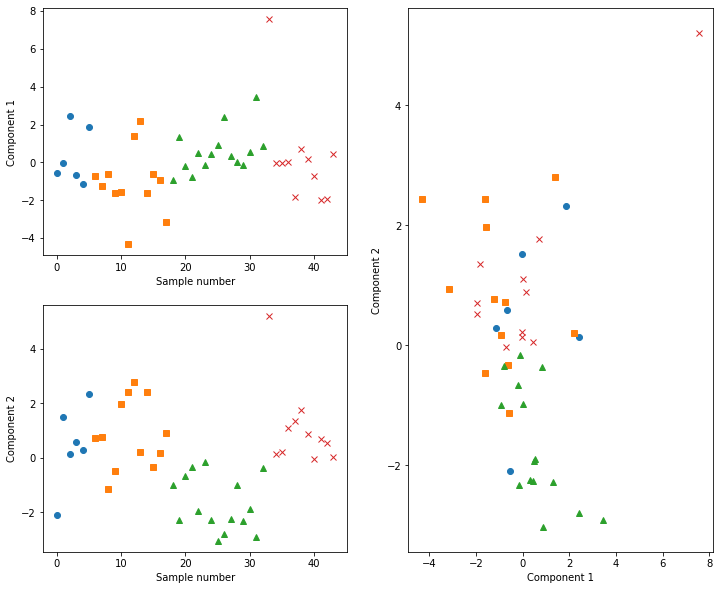

In [18]:
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(2, 2) 
ax0 = plt.subplot(gs[0, 0])
for i in range(1, 5):
    ax0.plot(data.where(data['Country'] == i)['PC1'], m[i])
ax0.set_xlabel('Sample number')
ax0.set_ylabel('Component 1')
ax1 = plt.subplot(gs[1, 0])
for i in range(1, 5):
    ax1.plot(data.where(data['Country'] == i)['PC2'], m[i])
ax1.set_xlabel('Sample number')
ax1.set_ylabel('Component 2')
ax2 = plt.subplot(gs[:, 1])
for i in range(1, 5):
    plt.plot(data.where(data['Country'] == i)['PC1'], data.where(data['Country'] == i)['PC2'], m[i])
ax2.set_xlabel('Component 1')
ax2.set_ylabel('Component 2')
plt.show()